In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle

<ipython-input-1-57267a77b0ab>:21: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
#### clrs at 1kb,5kb,10kb
clr_notag_1kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_1000_raw.cool")
clr_top2_1kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK09_JK10_30_1000_raw.cool")
clr_top1_1kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK14_combined_JK93_30_1000_raw.cool")

clr_notag_5kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_5000_raw.cool")
clr_top2_5kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK09_JK10_30_5000_raw.cool")
clr_top1_5kb = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK14_combined_JK93_30_5000_raw.cool")


####### ps at 500b
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_500_raw.cool")
clr_top2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK09_JK10_30_500_raw.cool")
clr_top1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK14_combined_JK93_30_500_raw.cool")

clr_notag_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_30_500_raw.cool")
clr_notag_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK08_30_500_raw.cool")

clr_top2_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK09_30_500_raw.cool")
clr_top2_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK10_30_500_raw.cool")

clr_top1_1 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK93_30_500_raw.cool")
clr_top1_2 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK14_combined_30_500_raw.cool")



In [3]:
# ChIPseq data
bw_notag_inputsubt = pyBigWig.open("/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version1/ChIP/inputsubt/DPY-27_CA1200_1h_auxin_AKM189_AKM211_inputsubt_averageFIX.bw")
bw_top2_inputsubt = pyBigWig.open("/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version1/ChIP/inputsubt/DPY-27_SS01A_1h_auxin_AKM104_AK148_inputsubt_averageFIX.bw")
bw_top1_inputsubt = pyBigWig.open("/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version1/ChIP/inputsubt/DPY-27_AM05_1h_auxin_AKM171_AKM240_inputsubt_averageFIX.bw")

# ins data
bw_notag_ins = pyBigWig.open("/scratch/kimj50/Jun_HiC/topo2_revision/hicFindTADs_bw/JK07_JK08_10000_score.bw")
bw_top2_ins = pyBigWig.open("/scratch/kimj50/Jun_HiC/topo2_revision/hicFindTADs_bw/JK09_JK10_10000_score.bw")
bw_top1_ins = pyBigWig.open("/scratch/kimj50/Jun_HiC/topo2_revision/hicFindTADs_bw/JK14_combined_JK93_10000_score.bw")

bw_top2_subt_ins = pyBigWig.open("/scratch/kimj50/Jun_HiC/topo2_revision/hicFindTADs_bw/JK09_JK10_subt_JK07_JK08_10000_score.bw")
bw_top1_subt_ins = pyBigWig.open("/scratch/kimj50/Jun_HiC/topo2_revision/hicFindTADs_bw/JK14_combined_JK93_subt_JK07_JK08_10000_score.bw")



In [4]:
#### chromosome wide ####
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)

#### annotation strong rex ####
strong = bioframe.read_table("/scratch/kimj50/annotation/sarah_strong.bed",schema='bed').iloc[:,:3]
interm = bioframe.read_table("/scratch/kimj50/annotation/sarah_intermediate.bed",schema='bed').iloc[:,:3]


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size)

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,chromsizes):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
    w = snipping.assign_regions(w, chromsizes)
    return w

nthreads = 2
def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_clr(clr,windows,regions):
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_pup_oe(clr,windows,regions,expected):
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

def bwTobedMatrix(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = "".join(['chr', region['chrom'][i]]) # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            v = bw.stats(chrom,
                         lst_region[0].reset_index(drop=True)[i],
                         lst_region[1].reset_index(drop=True)[i],
                         type='mean',nBins=nbins)
            
            lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)

def bwTobedMatrix1(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = region['chrom'][i] # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            v = bw.stats(chrom,
                         lst_region[0].reset_index(drop=True)[i],
                         lst_region[1].reset_index(drop=True)[i],
                         type='mean',nBins=nbins)
            
            lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)

def compute_Amean(bigwig):
    chroms = ["chrI","chrII","chrIII","chrIV","chrV"]
    bw_stats = []
    for i in range(len(chroms)):
        stat_i = bigwig.stats(chroms[i],type="mean")[0]
        bw_stats.append(stat_i)
    return np.nanmean(bw_stats)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))



In [ ]:
#################################### beginning of Ps, combined data slopes, X/A ##########################################

#### Ps, combined dat split XA ####
clrs_conditions = [clr_notag,clr_top2,clr_top1]

agg_XA_clrs_conditions = []
for i in range(len(clrs_conditions)):
    agg_XA = []
    a = scaling_agg(clrs_conditions[i],ce10.iloc[0:4].reset_index(drop=True))
    x = scaling_agg(clrs_conditions[i],ce10.iloc[[5]].reset_index(drop=True))
    agg_XA.append(a)
    agg_XA.append(x)
    agg_XA_clrs_conditions.append(agg_XA)
    


In [8]:
########################################## Ps, slopes, reps, X/A ##########################################

#### Ps, reps split XA ####
clrs_reps = [clr_notag_1,clr_notag_2,
             clr_top2_1,clr_top2_2,
             clr_top1_1,clr_top1_2]

agg_XA_clrs_reps = []
for i in range(len(clrs_reps)):
    agg_XA = []
    a = scaling_agg(clrs_reps[i],ce10.iloc[0:4].reset_index(drop=True))
    x = scaling_agg(clrs_reps[i],ce10.iloc[[5]].reset_index(drop=True))
    agg_XA.append(a)
    agg_XA.append(x)
    agg_XA_clrs_reps.append(agg_XA)

In [9]:
########################################## Ps, slopes, per chr ##########################################


clrs_conditions = [clr_notag,clr_top2,clr_top1]

agg_perchr_clrs = []
for i in range(len(clrs_conditions)):
    agg_perchr = []
    for j in range(ce10.shape[0]):
        x = scaling_agg(clrs_conditions[i],ce10.iloc[[j]].reset_index(drop=True))
        agg_perchr.append(x)
    agg_perchr_clrs.append(agg_perchr)


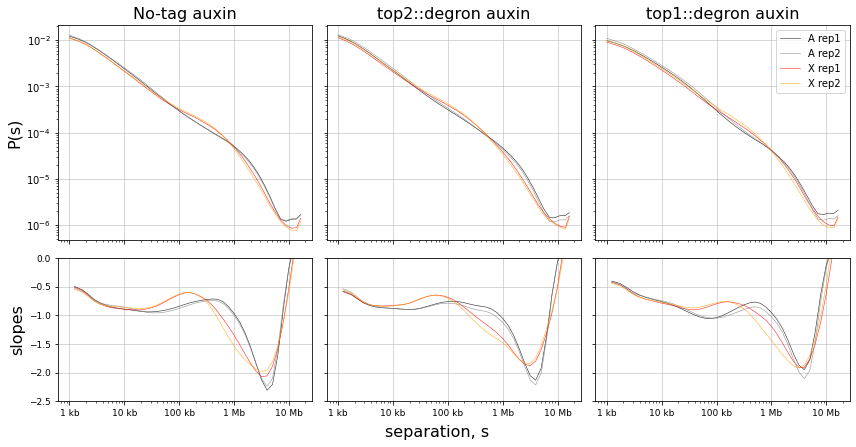

In [10]:
########################## Ps, slopes, split reps ############################
f, axs = plt.subplots(
    figsize=(12,6),
    ncols=3,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
notag_reps = [agg_XA_clrs_reps[0],agg_XA_clrs_reps[1]]
top2_reps = [agg_XA_clrs_reps[2],agg_XA_clrs_reps[3]]
top1_reps = [agg_XA_clrs_reps[4],agg_XA_clrs_reps[5]]
sample_grps = [notag_reps,top2_reps,top1_reps]
# structure: layer1=conditions, layer2=reps, layer3=A,X, layer4=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.6
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['No-tag auxin','top2::degron auxin','top1::degron auxin']
labels = [['A rep1','X rep1'], ['A rep2', 'X rep2']]
colors = [['black','red'],['grey','orange']]

# plot #
for s in range(len(sample_grps)):
    dat_agg = sample_grps[s]
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for i in range(len(dat_agg)):
        for j in range(len(dat_agg[i])):
            ax1.loglog(
                dat_agg[i][j][0]['s_bp'],
                dat_agg[i][j][0]['balanced.avg'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
            ax2.semilogx(
                dat_agg[i][j][1]['s_bp'],
                dat_agg[i][j][1]['slope'],
                label=labels[i][j],
                color=colors[i][j],linewidth=lineWidth,alpha=Alpha
            )
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.51, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
order = [0,2,1,3]
axs[0,2].legend([handles[idx] for idx in order],[labels[idx] for idx in order])



plt.tight_layout()

In [11]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/Ps_reps_XAsplit_HiC500b.pdf',dpi=800,bbox_inches='tight')

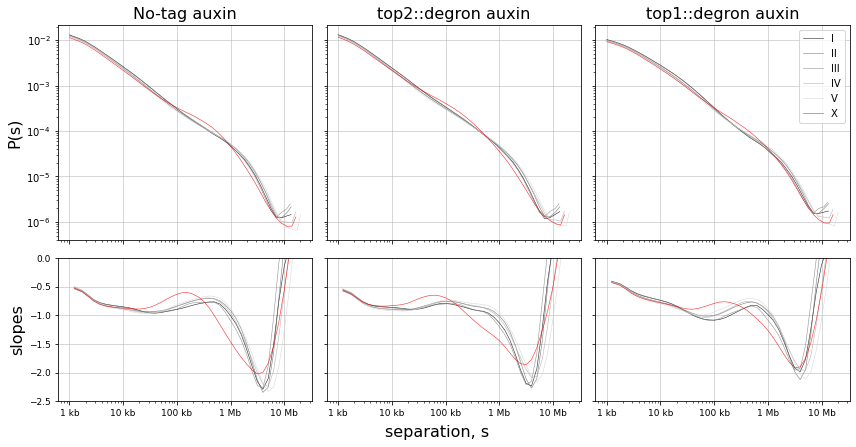

In [12]:
########################## Ps, slopes, per chromosome ############################
f, axs = plt.subplots(
    figsize=(12,6),
    ncols=3,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
sample_grps = agg_perchr_clrs
# structure: layer1=conditions, layer2=chromosomes, layer3=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.6
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['No-tag auxin','top2::degron auxin','top1::degron auxin']
labels = ['I','II','III','IV','V','X']
colors = ['black','dimgrey','grey','darkgrey','lightgrey','red']

# plot #
for s in range(len(sample_grps)):
    dat_agg = sample_grps[s]
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for j in range(len(dat_agg)):
        ax1.loglog(
            dat_agg[j][0]['s_bp'],
            dat_agg[j][0]['balanced.avg'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
        ax2.semilogx(
            dat_agg[j][1]['s_bp'],
            dat_agg[j][1]['slope'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.51, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
axs[0,2].legend()


plt.tight_layout()


In [13]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/Ps_perchr_HiC500b.pdf',dpi=800,bbox_inches='tight')

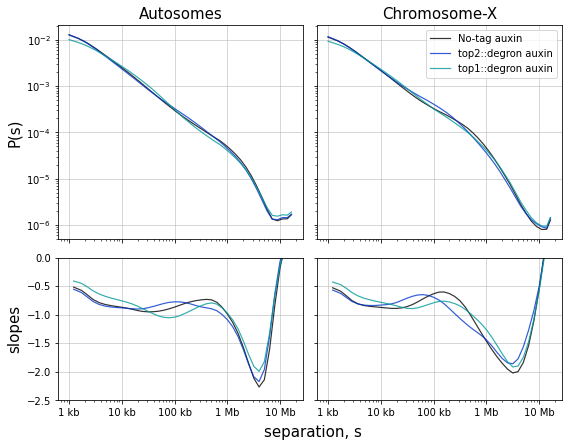

In [153]:
########################## PsX,psA, chromosome grouped ############################
f, axs = plt.subplots(
    figsize=(8,6),
    ncols=2,
    nrows=2,
    sharex=True, sharey='row',
    gridspec_kw={'height_ratios':[6,4]}
)

# sample grouping #
dat_agg = agg_XA_clrs_conditions
# structure: layer1=conditions, layer2=A,X, layer3=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 0.6
bigFont = 16
smallFont = 9
slopes_minmax = [-2.5,0]
subtitles = ['Autosomes','Chromosome-X']
labels = ['No-tag auxin',
          'top2::degron auxin',
          'top1::degron auxin']

colors = ['#000000','#0033CC', '#009999']

# global params and labels #
Alpha = 0.8
lineWidth = 1.2
bigFont = 15
smallFont = 10


# plot #
for s in range(2):
    ax1 = axs[0,s]
    ax2 = axs[1,s]
    for j in range(len(dat_agg)):
        ax1.loglog(
            dat_agg[j][s][0]['s_bp'],
            dat_agg[j][s][0]['balanced.avg'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
        ax2.semilogx(
            dat_agg[j][s][1]['s_bp'],
            dat_agg[j][s][1]['slope'],
            label=labels[j],
            color=colors[j],linewidth=lineWidth,alpha=Alpha
        )
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    format_ticks(ax2,y=False,rotate=False)
    ax2.tick_params(labelsize=smallFont)
    ax2.set_ylim(slopes_minmax)
    
    ax1.set_title(subtitles[s],size=bigFont)

# ylabel
axs[0,0].set_ylabel('P(s)',size=bigFont)
axs[1,0].set_ylabel('slopes',size=bigFont)

# big xlabel
f.text(0.55, -0.02, 'separation, s', ha='center',fontsize=bigFont)

#add legend to plot
handles, labels = axs[0,1].get_legend_handles_labels()
axs[0,1].legend()


plt.tight_layout()




In [154]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/Ps_A_separate_X_HiC500b.pdf',dpi=800,bbox_inches='tight')

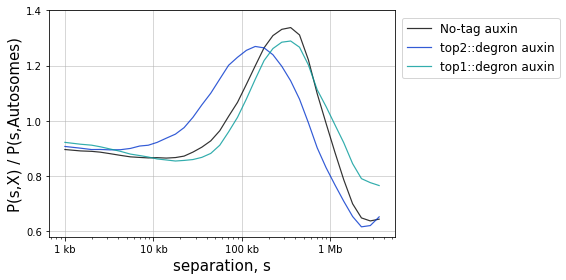

In [23]:
########################## PsX/psA, combined ############################
f, axs = plt.subplots(
    figsize=(8,4),
    ncols=1,
    nrows=1
)

# sample grouping #
agg_XA_clrs_conditions
# structure: layer1=conditions, layer2=A,X, layer3=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.8
lineWidth = 1.2
bigFont = 15
smallFont = 10
xMax = 4000000
labels = ['No-tag auxin',
          'top2::degron auxin',
          'top1::degron auxin']

colors = ['#000000','#0033CC', '#009999']



ax=axs
for r in range(len(agg_XA_clrs_conditions)):
    dat_agg = agg_XA_clrs_conditions[r]
    xbool = dat_agg[1][0]['s_bp']<=xMax
    ax.semilogx(
        dat_agg[1][0]['s_bp'][xbool],
        dat_agg[1][0]['balanced.avg'][xbool] / dat_agg[0][0]['balanced.avg'][xbool],
        alpha=Alpha,linewidth=lineWidth,
        label=labels[r],color=colors[r])
ax.grid(lw=0.5)
format_ticks(ax,y=False,rotate=False)
ax.tick_params(labelsize=smallFont)
ax.axes.set_yticks([0.6,0.8,1,1.2,1.4])

# xy labels
ax.set_ylabel('P(s,X) / P(s,Autosomes)',size=bigFont)
ax.set_xlabel('separation, s',size=bigFont)



ax.legend(loc=(1.02,0.7),prop={'size': 12})
plt.tight_layout()

In [24]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/Ps_XAratio_HiC500b.pdf',dpi=800,bbox_inches='tight')

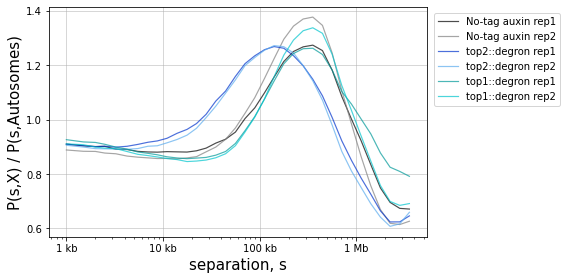

In [28]:
########################## PsX/psA, split reps ############################
f, axs = plt.subplots(
    figsize=(8,4),
    ncols=1,
    nrows=1
)

# sample grouping #
agg_XA_clrs_reps
# structure: layer1=reps, layer2=A,X, layer3=ps,slopes,loopsize #

# global params and labels #
Alpha = 0.7
lineWidth = 1.2
bigFont = 15
smallFont = 10
xMax = 4000000
labels = ['No-tag auxin rep1','No-tag auxin rep2',
          'top2::degron rep1','top2::degron rep2',
          'top1::degron rep1','top1::degron rep2']

colors = ['#000000','#808080',
          '#0033CC', '#5CACEE',
          '#009999','#00C5CD']


ax=axs
for r in range(len(agg_XA_clrs_reps)):
    dat_agg = agg_XA_clrs_reps[r]
    xbool = dat_agg[1][0]['s_bp']<=xMax
    ax.semilogx(
        dat_agg[1][0]['s_bp'][xbool],
        dat_agg[1][0]['balanced.avg'][xbool] / dat_agg[0][0]['balanced.avg'][xbool],
        alpha=Alpha,linewidth=lineWidth,
        label=labels[r],color=colors[r])
ax.grid(lw=0.5)
format_ticks(ax,y=False,rotate=False)
ax.tick_params(labelsize=smallFont)
ax.axes.set_yticks([0.6,0.8,1,1.2,1.4])

# xy labels
ax.set_ylabel('P(s,X) / P(s,Autosomes)',size=bigFont)
ax.set_xlabel('separation, s',size=bigFont)



ax.legend(loc=(1.02,0.57))
plt.tight_layout()

In [29]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/Ps_reps_XAratio_HiC500b.pdf',dpi=800,bbox_inches='tight')

In [79]:
########## pile-ups at rex #################
flank=500000
resolution=5000
ce10_X = ce10.iloc[[5]].reset_index(drop=True)
add_mid(strong)
windows_strong = add_windows(strong,ce10_X)



In [80]:
########### expected X for oe ###############

clrs_cond = [clr_notag_5kb,clr_top2_5kb,clr_top1_5kb]
clrs_cond_expX = []
for s in range(len(clrs_cond)):
    print(s)
    x = my_expected(clrs_cond[s],ce10.iloc[[5]].reset_index(drop=True))
    clrs_cond_expX.append(x)




0
1
2


In [82]:
#### pile up strong ####
pup_obs_oe = []
for s in range(len(clrs_cond_expX)):
    x = my_pup_clr(clrs_cond[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True))
    y = my_pup_oe(clrs_cond[s],windows_strong,ce10.iloc[[5]].reset_index(drop=True),clrs_cond_expX[s])
    pup_obs_oe.append([x,y])



<ipython-input-10-7f9a88028698>:76: RuntimeWarning: Mean of empty slice
  expected_avg = np.nanmean(oe_stack, axis=2)


<ipython-input-140-4d304c54b9af>:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


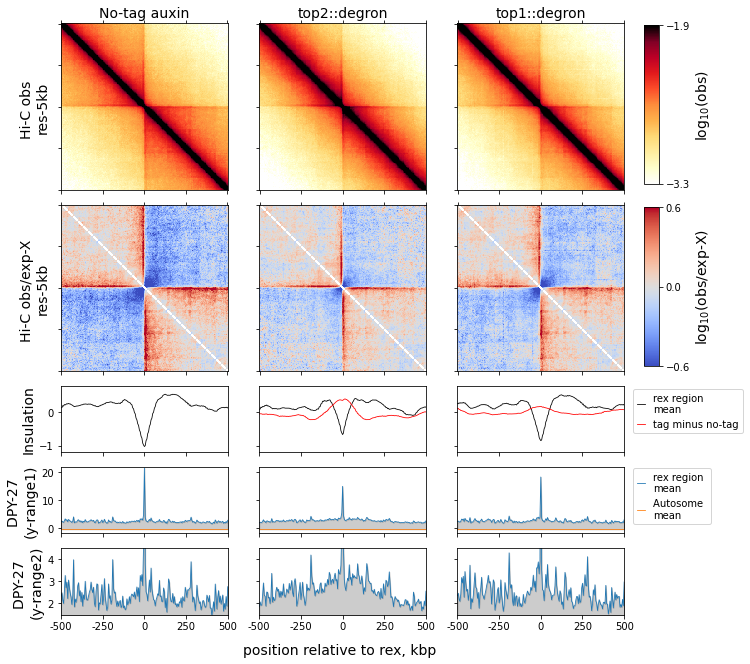

In [140]:
################## rex pileup bw input subt ##############

f, axs = plt.subplots(
    figsize=(9,10),
    ncols=3,nrows=1,
    sharey=True,
    sharex=True)
                

start, end = [0,flank*2//resolution]
ticks_pixels = np.linspace(0, flank*2//resolution,5)
ticks_kbp = ((ticks_pixels-ticks_pixels[-1]/2)*resolution//1000).astype(int)


bws = [bw_notag_inputsubt,bw_top2_inputsubt,bw_top1_inputsubt]
bws_ins = [bw_notag_ins,bw_top2_ins,bw_top1_ins]
bws_subt_ins = [bw_top2_subt_ins,bw_top1_subt_ins]

#pup_obs_oe
# structure: layer1=conditions,layer2=obs,obs/exp

# global params and labels #
Alpha = 0.8
lineWidth = 0.8
bigFont = 14
smallFont = 10
minmax_oe = [-0.6,0.6]
minmax_o = [-3.3,-1.9]

minmax_bw_ins = [-1.2,0.8]
minmax_bw1 = [-2,22]
minmax_bw2 = [1.5,4.5]


sub_titles = ['No-tag auxin','top2::degron','top1::degron']


for s in range(len(pup_obs_oe)):
    ax_oe = axs[s]
    
    ## obs/exp ##
    im_oe = ax_oe.matshow(
        np.log2(pup_obs_oe[s][1]),
        cmap='coolwarm',
        vmin=minmax_oe[0],vmax=minmax_oe[1]
    )
    divider = make_axes_locatable(ax_oe)
    
    ## obs ##
    ax_o = divider.append_axes("top", size="100%", pad=0.2)
    im_o = ax_o.matshow(
        np.log10(pup_obs_oe[s][0]),
        cmap='fall',
        vmin=minmax_o[0],vmax=minmax_o[1]
    )
    
    ## insul ##
    ax0 = divider.append_axes("bottom", size="40%", pad=0.2)
    xval = np.linspace(start, end,len(pup_obs_oe[s][1]))
    a = bwTobedMatrix1(bws_ins[s],windows_strong,len(pup_obs_oe[s][1]))
    yval = np.nanmean(a,axis=0,dtype=float)
    mask = np.isfinite(yval)
    ax0.plot(
        xval[mask],
        yval[mask],lw=lineWidth,color='black',label='rex region \nmean')
    ax0.set_xlim([xval.min(), xval.max()])
    ax0.set_ylim([minmax_bw_ins[0],minmax_bw_ins[1]])    
    
    if s > 0:
        a = bwTobedMatrix1(bws_subt_ins[s-1],windows_strong,len(pup_obs_oe[s][1]))
        yval = np.nanmean(a,axis=0,dtype=float)
        ax0.plot(
            xval[mask],
            yval[mask],lw=lineWidth,color='red',label='tag minus no-tag')
    
    ## DPY27 yaxis1 ##
    ax1 = divider.append_axes("bottom", size="40%", pad=0.2)
    xval = np.linspace(start, end,len(pup_obs_oe[s][1]))
    a = bwTobedMatrix(bws[s],windows_strong,len(pup_obs_oe[s][1]))
    yval = np.nanmean(a,axis=0,dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(
        xval[mask],
        yval[mask],lw=lineWidth, label='rex region \nmean')
    yval_A = np.repeat(compute_Amean(bws[s]),len(yval))
    ax1.plot(
        xval[mask],
        yval_A[mask],lw=lineWidth,label='Autosome \nmean')
    ax1.fill_between(xval[mask],yval_A[mask],yval[mask],interpolate=False, alpha=0.2,color="black")
    ax1.set_xlim([xval.min(), xval.max()])
    ax1.set_ylim([minmax_bw1[0],minmax_bw1[1]])
    
    ## DPY27 yaxis2 ##
    ax2 = divider.append_axes("bottom", size="40%", pad=0.2)
    ax2.plot(
        xval[mask],
        yval[mask],lw=lineWidth, label='rex pileup')
    ax2.plot(
        xval[mask],
        yval_A[mask],lw=lineWidth,label='A mean')
    ax2.fill_between(xval[mask],yval_A[mask],yval[mask],interpolate=False, alpha=0.2,color="black")
    ax2.set_xlim([xval.min(), xval.max()])
    ax2.set_ylim([minmax_bw2[0],minmax_bw2[1]])
    
    
    
    ### labeling
    ax_oe.set(xticks=ticks_pixels,yticks=ticks_pixels,xticklabels=[],yticklabels=[])
    ax_o.set(xticks=ticks_pixels,yticks=ticks_pixels,xticklabels=[],yticklabels=[])
    ax_o.set_title(sub_titles[s],fontsize=bigFont)
    ax0.set(xticks=ticks_pixels,xticklabels=[])
    ax1.set(xticks=ticks_pixels,xticklabels=[])
    ax2.set(xticks=ticks_pixels,xticklabels=ticks_kbp)
    
    
    # asthetics
    ax0.tick_params(labelsize=smallFont)
    ax1.tick_params(labelsize=smallFont)
    ax2.tick_params(labelsize=smallFont)
    if s == 0 :
        ax_o.set_ylabel('Hi-C obs \nres-5kb',fontsize=bigFont)
        ax_oe.set_ylabel('Hi-C obs/exp-X \nres-5kb',fontsize=bigFont)
        ax0.set_ylabel('Insulation',fontsize=bigFont)
        ax1.set_ylabel('DPY-27 \n(y-range1)',fontsize=bigFont)
        ax2.set_ylabel('DPY-27 \n(y-range2)',fontsize=bigFont)
        
        
    else:
        ax0.set(yticklabels=[])
        ax1.set(yticklabels=[])
        ax2.set(yticklabels=[])
    
cbaxes_o = f.add_axes([1.000001, .688, 0.022, 0.22])  
cbar_o = plt.colorbar(im_o, cax = cbaxes_o,ticks=[minmax_o[0],minmax_o[1]])
cbar_o.ax.set_ylabel('$\log_{10}$(obs)', rotation=90,fontsize=bigFont)
cbar_o.ax.get_yaxis().labelpad = 4

cbaxes_oe = f.add_axes([1.000001, .435, 0.022, 0.22])  
cbar_oe = plt.colorbar(im_oe, cax = cbaxes_oe,ticks=[minmax_oe[0],0,minmax_oe[1]])
cbar_oe.ax.set_ylabel('$\log_{10}$(obs/exp-X)', rotation=90,fontsize=bigFont)
cbar_oe.ax.get_yaxis().labelpad = 4

handles, labels = ax0.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.16, 0.41),prop={'size': 10},
               handlelength=0.8)
leg._legend_box.align = "left"

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.11, 0.30),prop={'size': 10},
               handlelength=0.8)
leg._legend_box.align = "left"

f.text(0.53, 0.035, 'position relative to rex, kbp', ha='center',fontsize=bigFont)
    
plt.tight_layout()

In [141]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/rex_PileUp_HiC5kb_ChIPinputsubt_insulation.pdf',dpi=800,bbox_inches='tight')

/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
<ipython-input-111-fd5f5d1a62b5>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


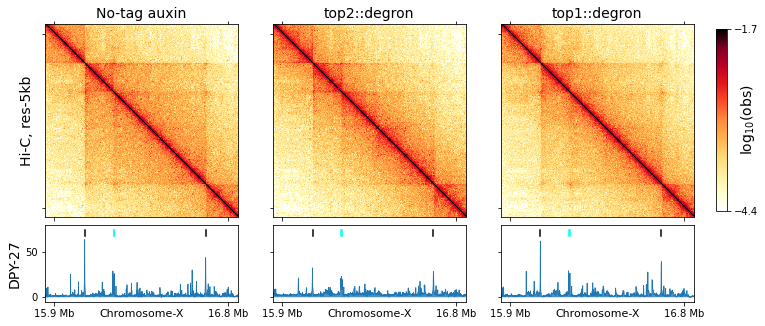

In [111]:
###### plot 1mb region of X and A with insulation score and chipseq

f, axs = plt.subplots(
    figsize=(10, 6),
    nrows=1,
    ncols=3,
    sharex='col',
    sharey='row'
)

### adjust vmin/max here to adjust the color range


minmax_o = [-4.4,-1.7]
############################################## plot 1mb region of X ############################################
region = 'X:15,850,000-16,850,000'
start, end = 15_850_000, 16_850_000
extents = (start, end, end, start)

Alpha = 0.8
lineWidth = 0.8
bigFont = 14
smallFont = 11

clrs = [clr_notag_1kb,clr_top2_1kb,clr_top1_1kb]
bws = [bw_notag_inputsubt,bw_top2_inputsubt,bw_top1_inputsubt]
minmax_bw1 = [-5,80]
ticks = [15_900_000,16_800_000]
sub_titles = ['No-tag auxin','top2::degron','top1::degron']

for i in range(len(clrs)):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_o[0],vmax=minmax_o[1],
        extent=extents
    )
    divider = make_axes_locatable(ax)
    
    ######### chrX DPY27 #########
    ax1 = divider.append_axes("bottom", size='40%', pad=0.1)
    bw_region = bws[i].stats('chrX',start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(
        xval[mask],
        yval[mask],lw=lineWidth)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=Alpha)
    ax1.set_ylim([minmax_bw1[0],minmax_bw1[1]])
    plt.xlim([xval.min(), xval.max()])
    format_ticks(ax,rotate=0)
    format_ticks(ax1,x=True,y=False,rotate=0)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=False)
    ax.axes.get_yaxis().set_ticklabels([])

    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax1.set_xticks(ticks)
    ax.set_title(sub_titles[i],fontsize=bigFont)
    ax1.set_xlabel('Chromosome-X',fontsize=smallFont,labelpad=-10)
    if i == 0:
        ax.set_ylabel('Hi-C, res-5kb',fontsize=bigFont)
        ax1.set_ylabel('DPY-27',fontsize=bigFont)
    if i > 0:
        ax1.set_yticklabels([])
    ##### annot #####
    strong_annot = bed3_mids(strong,'X',start,end)
    intermediate_annot = bed3_mids(interm,'X',start,end)
    for a in range(len(strong_annot)):
        ax1.axvline(x=strong_annot[a],ymin=0.85,ymax=0.93,c="black",alpha=1,label='strong rex')
    for a in range(len(intermediate_annot)):
        ax1.axvline(x=intermediate_annot[a],ymin=0.85,ymax=0.93,c="cyan",alpha=1,label='interm. rex')
        
## cbar ##
cbaxes = f.add_axes([1, .390, 0.015, 0.42])
cbar = plt.colorbar(im, cax = cbaxes,ticks=[minmax_o[0],minmax_o[1]])
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel('$\log_{10}$(obs)', rotation=90,fontsize=bigFont,labelpad=-20)



plt.tight_layout()

In [112]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/topo2_revision/version3/snapshot_HiC1kb_ChIPinputsubt.pdf',dpi=800,bbox_inches='tight')